In [29]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy import stats
from numba import njit
import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

In [30]:
### Table to store our results in
latex_all_period = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'])

                      UMV  CMV_k  CMV_m
Mean               0.4997 0.5758 0.5743
Standard deviation 0.3060 0.3603 0.3297
Sharpe ratio       1.6332 1.5983 1.7415
p-value               NaN 0.2362 0.0279
alpha                 NaN 1.6955 6.7968
t(alpha)              NaN 0.6696 2.0589


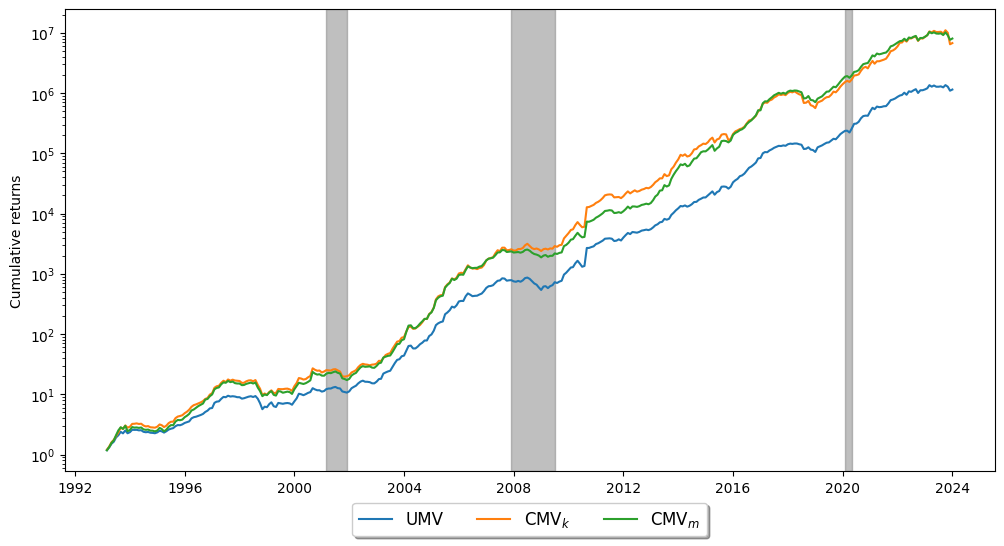

In [31]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility['VW']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['VW']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r = factor_ret_m.iloc[1:,]

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='none')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='none')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='none')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='none')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='none')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='none')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * r.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha)', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k  CMV_m
Mean               0.3720 0.4526 0.4507
Standard deviation 0.2949 0.3513 0.3224
Sharpe ratio       1.2614 1.2884 1.3981
p-value               NaN 0.1051 0.0063
alpha                 NaN 3.9125 6.5096
t(alpha)              NaN 1.3294 2.4518


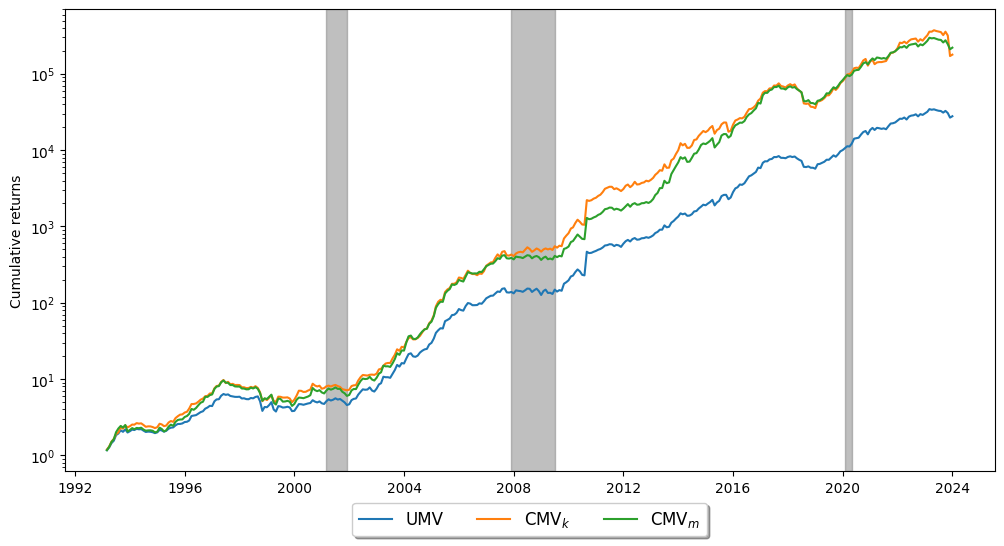

In [34]:
### Setting gamma
factor_to_drop = 'VW'

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r.drop(columns=factor_to_drop)
data_m = pd.concat([data_o, r_sigma_m.drop(columns=factor_to_drop)], axis=1)
data_k = pd.concat([data_o, r_sigma_k.drop(columns=factor_to_drop)], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio (wihout {factor_to_drop})', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value (wihout {factor_to_drop})', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha (wihout {factor_to_drop})', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha) (wihout {factor_to_drop})', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k  CMV_m
Mean               0.4994 0.5740 0.5747
Standard deviation 0.3048 0.3590 0.3296
Sharpe ratio       1.6386 1.5987 1.7440
p-value               NaN 0.2331 0.0256
alpha                 NaN 1.5790 6.6521
t(alpha)              NaN 0.6295 2.1068


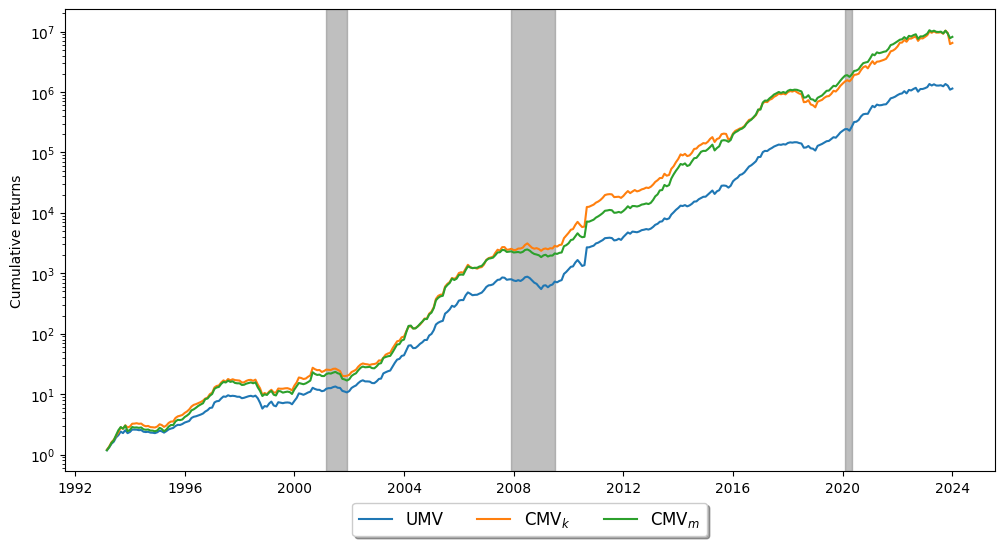

In [36]:
### Setting gamma
factor_to_drop = 'EW'

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r.drop(columns=factor_to_drop)
data_m = pd.concat([data_o, r_sigma_m.drop(columns=factor_to_drop)], axis=1)
data_k = pd.concat([data_o, r_sigma_k.drop(columns=factor_to_drop)], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio (wihout {factor_to_drop})', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value (wihout {factor_to_drop})', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha (wihout {factor_to_drop})', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha) (wihout {factor_to_drop})', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k  CMV_m
Mean               0.3378 0.3846 0.4025
Standard deviation 0.2328 0.2779 0.2770
Sharpe ratio       1.4514 1.3840 1.4528
p-value               NaN 0.2781 0.0166
alpha                 NaN 0.3812 2.1883
t(alpha)              NaN 0.1622 1.3024


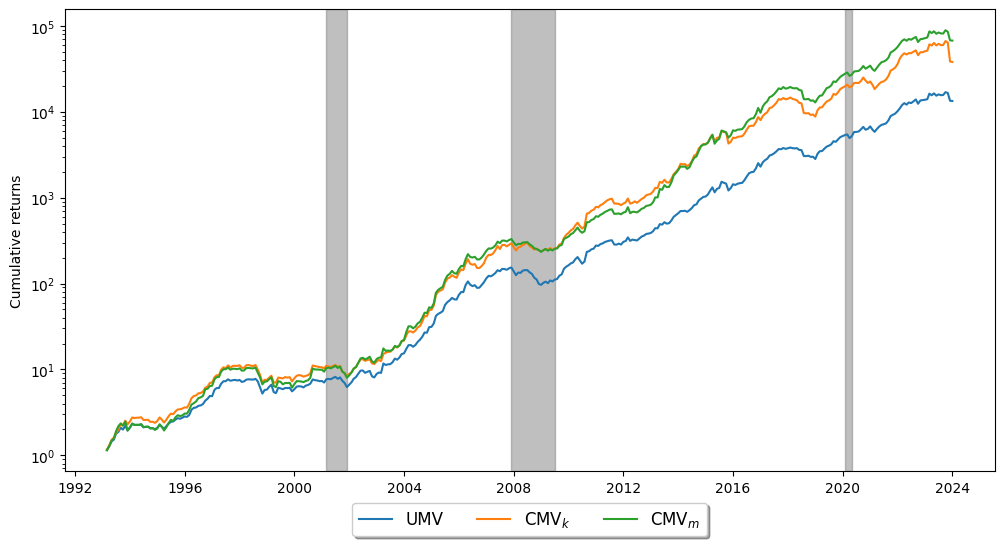

In [37]:
### Setting gamma
factor_to_drop = 'SMB'

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r.drop(columns=factor_to_drop)
data_m = pd.concat([data_o, r_sigma_m.drop(columns=factor_to_drop)], axis=1)
data_k = pd.concat([data_o, r_sigma_k.drop(columns=factor_to_drop)], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio (wihout {factor_to_drop})', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value (wihout {factor_to_drop})', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha (wihout {factor_to_drop})', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha) (wihout {factor_to_drop})', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k  CMV_m
Mean               0.4586 0.5159 0.5155
Standard deviation 0.2503 0.2860 0.2844
Sharpe ratio       1.8323 1.8042 1.8129
p-value               NaN 0.2352 0.0323
alpha                 NaN 2.0521 2.3658
t(alpha)              NaN 0.9239 1.4920


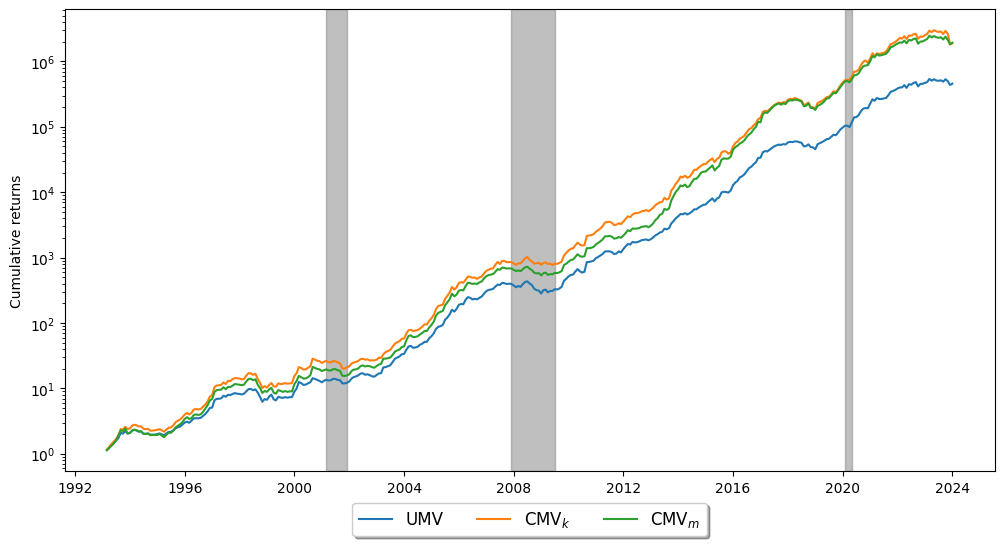

In [38]:
### Setting gamma
factor_to_drop = 'HML'

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r.drop(columns=factor_to_drop)
data_m = pd.concat([data_o, r_sigma_m.drop(columns=factor_to_drop)], axis=1)
data_k = pd.concat([data_o, r_sigma_k.drop(columns=factor_to_drop)], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio (wihout {factor_to_drop})', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value (wihout {factor_to_drop})', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha (wihout {factor_to_drop})', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha) (wihout {factor_to_drop})', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k  CMV_m
Mean               0.4238 0.4646 0.5074
Standard deviation 0.2795 0.3172 0.2969
Sharpe ratio       1.5163 1.4649 1.7090
p-value               NaN 0.2176 0.0283
alpha                 NaN 0.6401 8.5461
t(alpha)              NaN 0.2795 2.9058


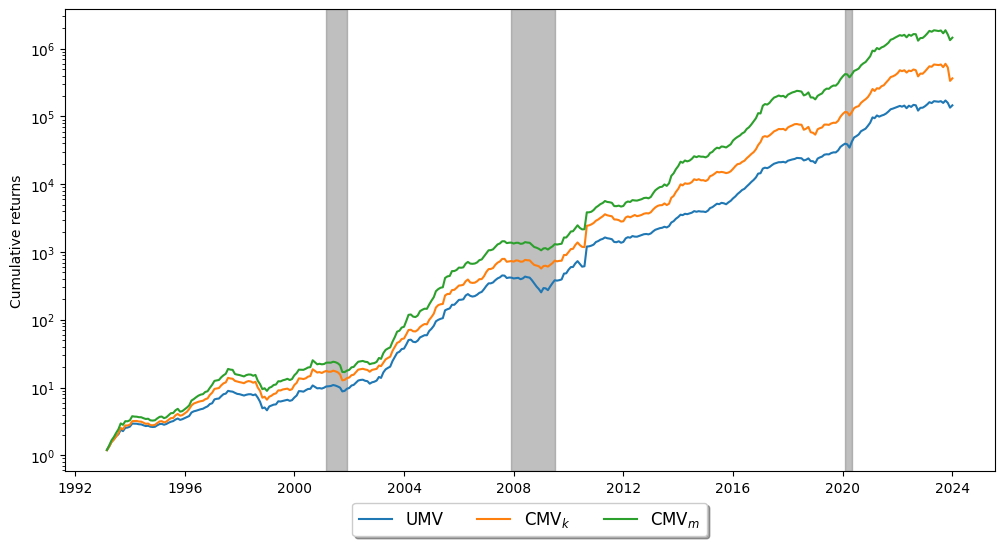

In [39]:
### Setting gamma
factor_to_drop = 'UMD'

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r.drop(columns=factor_to_drop)
data_m = pd.concat([data_o, r_sigma_m.drop(columns=factor_to_drop)], axis=1)
data_k = pd.concat([data_o, r_sigma_k.drop(columns=factor_to_drop)], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio (wihout {factor_to_drop})', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value (wihout {factor_to_drop})', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha (wihout {factor_to_drop})', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha) (wihout {factor_to_drop})', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

                      UMV  CMV_k  CMV_m
Mean               0.3932 0.4407 0.4509
Standard deviation 0.3095 0.3435 0.3244
Sharpe ratio       1.2704 1.2830 1.3900
p-value               NaN 0.1825 0.1389
alpha                 NaN 1.9449 6.0673
t(alpha)              NaN 1.0505 2.3887


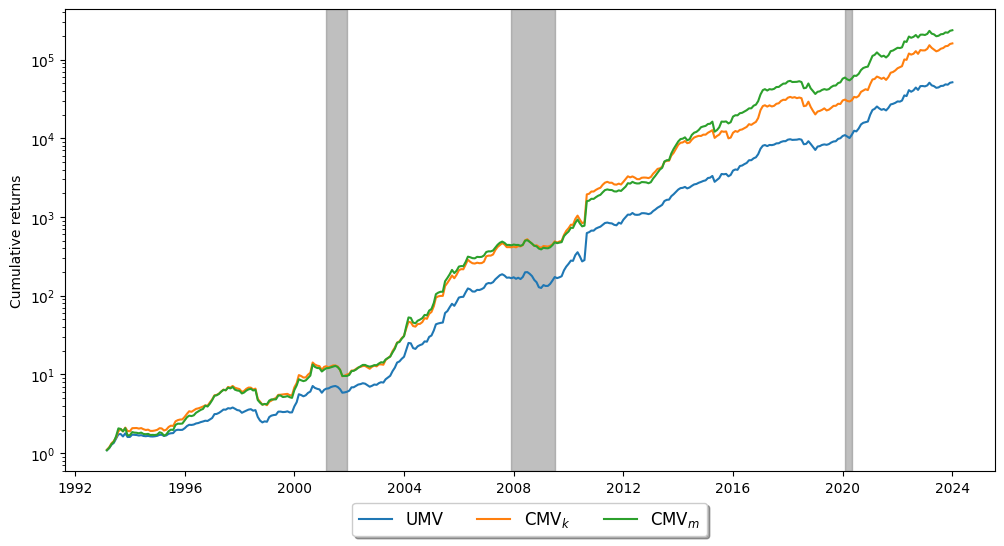

In [40]:
### Setting gamma
factor_to_drop = 'BAB'

### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r.drop(columns=factor_to_drop)
data_m = pd.concat([data_o, r_sigma_m.drop(columns=factor_to_drop)], axis=1)
data_k = pd.concat([data_o, r_sigma_k.drop(columns=factor_to_drop)], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']

### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

latex_all_period.loc[f'Sharpe ratio (wihout {factor_to_drop})', :] = latex.loc['Sharpe ratio', :].values
latex_all_period.loc[f'p-value (wihout {factor_to_drop})', :] = latex.loc['p-value', :].values
latex_all_period.loc[f'alpha (wihout {factor_to_drop})', :] = latex.loc['alpha', :].values
latex_all_period.loc[f't(alpha) (wihout {factor_to_drop})', :] = latex.loc['t(alpha)', :].values

#print(latex.to_latex(float_format="%.3f", na_rep=""))
print(latex)

### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.show()

In [41]:
print(latex_all_period.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{llll}
\toprule
 & UMV & CMV_k & CMV_m \\
\midrule
Sharpe ratio & 1.633 & 1.598 & 1.742 \\
p-value &  & 0.236 & 0.028 \\
alpha &  & 1.696 & 6.797 \\
t(alpha) &  & 0.670 & 2.059 \\
Sharpe ratio (wihout VW) & 1.261 & 1.288 & 1.398 \\
p-value (wihout VW) &  & 0.105 & 0.006 \\
alpha (wihout VW) &  & 3.912 & 6.510 \\
t(alpha) (wihout VW) &  & 1.329 & 2.452 \\
Sharpe ratio (wihout EW) & 1.639 & 1.599 & 1.744 \\
p-value (wihout EW) &  & 0.233 & 0.026 \\
alpha (wihout EW) &  & 1.579 & 6.652 \\
t(alpha) (wihout EW) &  & 0.630 & 2.107 \\
Sharpe ratio (wihout SMB) & 1.451 & 1.384 & 1.453 \\
p-value (wihout SMB) &  & 0.278 & 0.017 \\
alpha (wihout SMB) &  & 0.381 & 2.188 \\
t(alpha) (wihout SMB) &  & 0.162 & 1.302 \\
Sharpe ratio (wihout HML) & 1.832 & 1.804 & 1.813 \\
p-value (wihout HML) &  & 0.235 & 0.032 \\
alpha (wihout HML) &  & 2.052 & 2.366 \\
t(alpha) (wihout HML) &  & 0.924 & 1.492 \\
Sharpe ratio (wihout UMD) & 1.516 & 1.465 & 1.709 \\
p-value (wihout UMD) &  & 0.218 & 0.